# Trabajo Práctico 1: Enunciado


El trabajo práctico 1 de la materia se basa en el análisis de los tweets del set de datos de la competencia: https://www.kaggle.com/c/nlp-getting-started.  

- id - identificador unico para cada  tweet
- text - el texto del tweet
- location - ubicación desde donde fue enviado (podría no estar)
- keyword - un keyword para el tweet  (podría faltar)
- target - en train.csv, indica si se trata de un desastre real  (1) o no (0)

El objetivo del primer TP es realizar un análisis exploratorio del set de datos. Queremos ver qué cosas podemos descubrir sobre los datos que puedan resultar interesantes. Estas cosas pueden estar relacionadas al objetivo del TP2 (predecir si un cierto tweet es real o no) o no, ambas son de interés.

Los requisitos de la primera entrega son los siguientes:

- El análisis debe estar hecho en Python Pandas o R.
- El análisis debe entregarse en formato pdf vía gradescope. En el informe no va código.
- Informar el link a un repositorio Github en donde pueda bajarse el código completo para generar el análisis.

La evaluación del TP se realizará en base al siguiente criterio:

- Originalidad del análisis exploratorio. 
- Calidad del reporte. ¿Está bien escrito? ¿Es claro y preciso? 
- Calidad del análisis exploratorio: qué tipo de preguntas se hacen y de qué forma se responden, ¿es la respuesta clara y concisa con respecto a la pregunta formulada? 
- Calidad de las visualizaciones presentadas.
  - ¿Tienen todos los ejes su rótulo?
  - ¿Tiene cada visualización un título?
  - ¿Es entendible la visualización sin tener que leer la explicación?
  - ¿El tipo de plot elegido es adecuado para lo que se quiere visualizar?
  - ¿Es una visualización interesante?
  - ¿El uso del color es adecuado?
  - ¿Hay un exceso o falta de elementos visuales en la visualización elegida?
  - ¿La visualización es consistente con los datos?
- Conclusiones presentadas.


In [864]:
# Instalación de librerías a usar
# para escapear html
!pip3 install bs4
# para normalización del texto
!pip3 install nltk
!pip3 install stopwords
# visualización nube de palabras
!pip3 install wordcloud

In [865]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import string

from nltk.tokenize import sent_tokenize
from bs4 import BeautifulSoup
from html import unescape
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from collections import Counter

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs


warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [866]:
tweets = pd.read_csv('../data/train.csv', encoding='utf-8')
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Agregado de nuevas columnas y limpieza del dataset

In [867]:
# primera normalización del texto, pasamos a lowercase 
tweets['normalized_text'] = tweets.text.str.lower()
# solo para facilitar algunas visualizaciones
tweets['target_name']= np.where(tweets['target']==1 ,'SI','NO')

### Normalización del texto y nuevas columnas a partir del texto

#### Eliminamos los links del texto normalizado y guardamos los links en una columna a parte por si sirven a futuro

In [868]:
URLPATTERN = r'(https?://\S+)' 

tweets['urls'] = tweets.normalized_text.apply(lambda x: re.findall(URLPATTERN, x))
tweets['normalized_text'] = tweets.normalized_text.apply(lambda x: re.sub(URLPATTERN,"", x))
# cuento la cantidad de links en los tweets
tweets['url_count'] = tweets.urls.str.len()

#### Eliminamos los hashtags del texto normalizado y lo dejamos en otra columna junto con el count

In [869]:
# cuento la cantidad de hashtags en los tweets
# nueva columna con el total de hashtags, y los hashtags
tweets['hashtags'] = tweets.normalized_text.apply(lambda x: re.findall(r"#(\w+)", x))
tweets['hashtags_count'] = tweets.hashtags.str.len()
tweets['normalized_text'] = tweets.normalized_text.apply(lambda x: re.sub(r"#(\w+)","", x))

#### Eliminamos los tags del texto y lo dejamos en otra columna junto con el count

In [870]:
# cuento la cantidad de ags en los tweets
# nueva columna con el total de tags, y los tags
tweets['tags'] = tweets.text.str.lower().apply(lambda x: re.findall(r"@(\w+)", x))
tweets['normalized_text'] = tweets.normalized_text.apply(lambda x: re.sub(r"@(\w+)","", x))
tweets['tags_count'] = tweets.tags.str.len()

#### Contamos cantidad de oraciones

In [871]:
tweets['sentences_count'] = tweets.normalized_text.apply(lambda x : len(sent_tokenize(x))) 

#### Eliminamos signos de puntuación y html

In [872]:
translator = str.maketrans('', '', string.punctuation) 
# !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~

def remove_punctuation(text):        
    return text.translate(translator)

In [873]:
def remove_htmlsymbols(text):
    soup = BeautifulSoup(unescape(text))
    return soup.text

In [874]:
#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

def remove_emojis_non_ascii(text):    
    #replace consecutive non-ASCII characters with a space
    result = re.sub(r'[^\x00-\x7F]+',' ', text)
    #remove emojis from tweet
    result = emoji_pattern.sub(r'', result)    
    return result

In [875]:
tweets['normalized_text'] = tweets.normalized_text.apply(remove_htmlsymbols)
tweets['normalized_text'] = tweets.normalized_text.apply(remove_punctuation)
tweets['normalized_text'] = tweets.normalized_text.apply(remove_emojis_non_ascii)

#### Eliminamos stop words y creamos nueva columna con array de palabras

In [876]:
# convertimos el texto en listado de palabras y despues borramos las stop words
tweets['words'] = tweets.normalized_text.str.split()
stop_words = stopwords.words('english')
tweets['normalized_words'] = tweets['words'].apply(lambda x: [item for item in x if item not in stop_words])
# eliminar las stop words del texto normalizado
tweets['normalized_text'] = [' '.join(map(str, l)) for l in tweets['normalized_words']]
# vemos como queda el dataset
tweets.head()

,id,keyword,location,text,target,normalized_text,target_name,urls,url_count,hashtags,hashtags_count,tags,tags_count,sentences_count,words,normalized_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason may allah forgive us,SI,[],0,[earthquake],1,[],0,1,"[our, deeds, are, the, reason, of, this, may, ...","[deeds, reason, may, allah, forgive, us]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,SI,[],0,[],0,[],0,2,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,SI,[],0,[],0,[],0,2,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive evacuation orders california,SI,[],0,[wildfires],1,[],0,1,"[13000, people, receive, evacuation, orders, i...","[13000, people, receive, evacuation, orders, c..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby smoke pours school,SI,[],0,"[alaska, wildfires]",2,[],0,1,"[just, got, sent, this, photo, from, ruby, as,...","[got, sent, photo, ruby, smoke, pours, school]"


#### Analizamos si el texto tiene números y guardamos el dato en una nueva columna

In [877]:
# esto chequea números como 1,2 y tambíen escrito como one, two
def existence_of_numeric_data(text):
    text=nltk.word_tokenize(text)
    pos = nltk.pos_tag(text)
    count = 0
    for i in range(len(pos)):
        word , pos_tag = pos[i]
        if pos_tag == 'CD':
            return 1
    return 0

In [878]:
# con 1 si tiene , 0 sino
tweets['has_numbers'] = tweets.normalized_text.apply(existence_of_numeric_data)

### Normalización de la columna keyword

In [879]:
# eliminamos "%20" que representa espacio
tweets['keywords'] = tweets.keyword.str.replace('%20',' ')

### Correccion tipo de datos en keyword/location para optimizacion de memoria.

In [880]:
for col in ['keyword', 'location']:
    tweets[col] = tweets[col].astype('category')
#check de tipos de datos categoricos 
tweets.dtypes

id                     int64
keyword             category
location            category
text                  object
target                 int64
normalized_text       object
target_name           object
urls                  object
url_count              int64
hashtags              object
hashtags_count         int64
tags                  object
tags_count             int64
sentences_count        int64
words                 object
normalized_words      object
has_numbers            int64
keywords              object
dtype: object

### Agregado de columna para indicar si tiene o no location


In [881]:
#true si tiene location, false si no
tweets['has_location'] = ~tweets['location'].isna()
tweets.head()

,id,keyword,location,text,target,normalized_text,target_name,urls,url_count,hashtags,hashtags_count,tags,tags_count,sentences_count,words,normalized_words,has_numbers,keywords,has_location
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason may allah forgive us,SI,[],0,[earthquake],1,[],0,1,"[our, deeds, are, the, reason, of, this, may, ...","[deeds, reason, may, allah, forgive, us]",0,NaN,False
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,SI,[],0,[],0,[],0,2,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",0,NaN,False
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,SI,[],0,[],0,[],0,2,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...",0,NaN,False
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive evacuation orders california,SI,[],0,[wildfires],1,[],0,1,"[13000, people, receive, evacuation, orders, i...","[13000, people, receive, evacuation, orders, c...",1,NaN,False
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby smoke pours school,SI,[],0,"[alaska, wildfires]",2,[],0,1,"[just, got, sent, this, photo, from, ruby, as,...","[got, sent, photo, ruby, smoke, pours, school]",0,NaN,False


### Agregado de columnas para Análisis de sentimientos

In [882]:
sid = SentimentIntensityAnalyzer()

In [883]:
# Return a float for sentiment strength based on the input text. Positive values are positive valence, negative value are negative valence.
tweets['sentiment_score'] = tweets.normalized_text.apply(lambda x: sid.polarity_scores(x))
tweets['sentiment_score_compound'] = tweets.sentiment_score.apply(lambda x: x['compound'])
tweets['sentiment_score_pos'] = tweets.sentiment_score.apply(lambda x: x['pos'])
tweets['sentiment_score_neg'] = tweets.sentiment_score.apply(lambda x: x['neg'])

In [884]:
# vemos cómo queda el dataset
tweets.head()

,id,keyword,location,text,target,normalized_text,target_name,urls,url_count,hashtags,...,sentences_count,words,normalized_words,has_numbers,keywords,has_location,sentiment_score,sentiment_score_compound,sentiment_score_pos,sentiment_score_neg
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason may allah forgive us,SI,[],0,[earthquake],...,1,"[our, deeds, are, the, reason, of, this, may, ...","[deeds, reason, may, allah, forgive, us]",0,NaN,False,"{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'comp...",0.27,0.30,0.00
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,SI,[],0,[],...,2,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",0,NaN,False,"{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...",-0.34,0.00,0.29
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,SI,[],0,[],...,2,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...",0,NaN,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,0.00,0.00
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive evacuation orders california,SI,[],0,[wildfires],...,1,"[13000, people, receive, evacuation, orders, i...","[13000, people, receive, evacuation, orders, c...",1,NaN,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,0.00,0.00
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby smoke pours school,SI,[],0,"[alaska, wildfires]",...,1,"[just, got, sent, this, photo, from, ruby, as,...","[got, sent, photo, ruby, smoke, pours, school]",0,NaN,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,0.00,0.00


## Visualizaciones

### Cantidad de links

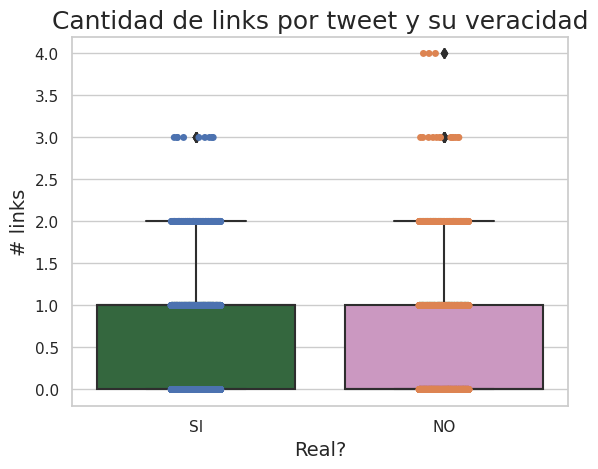

In [885]:
ax = sns.boxplot(x="target_name", y="url_count", data=tweets, palette="cubehelix")
ax = sns.stripplot(x="target_name", y="url_count", data=tweets) #scatterplot
ax.set_title("Cantidad de links por tweet y su veracidad", fontsize=18)
ax.set_xlabel("Real?", fontsize=14)
ax.set_ylabel("# links", fontsize=14)
plt.show()

### Números en el texto del tweet

In [886]:
tweets['has_numbers_name']= np.where(tweets['has_numbers']==1 ,'SI','NO')

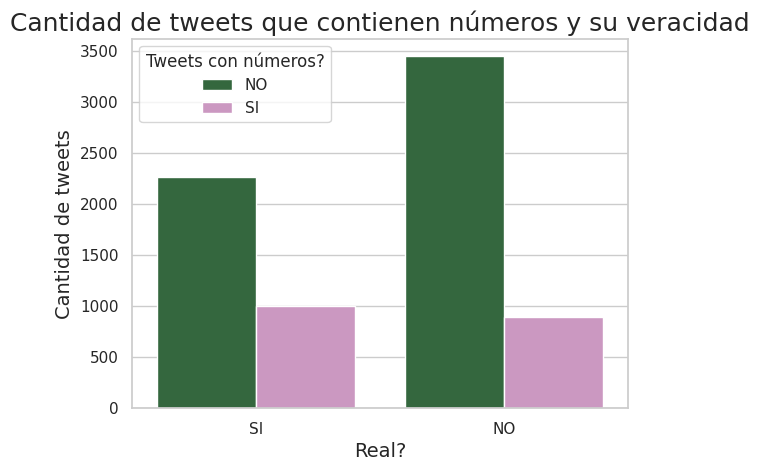

In [887]:
plot_tweets_numbers = sns.countplot(data=tweets,x="target_name", hue="has_numbers_name", palette="cubehelix")
plot_tweets_numbers.set_title("Cantidad de tweets que contienen números y su veracidad", fontsize=18)
plot_tweets_numbers.set_xlabel("Real?", fontsize=14)
plot_tweets_numbers.set_ylabel("Cantidad de tweets", fontsize=14)
plot_tweets_numbers.legend(loc='upper left', title='Tweets con números?')

### Cantidad de hashtags

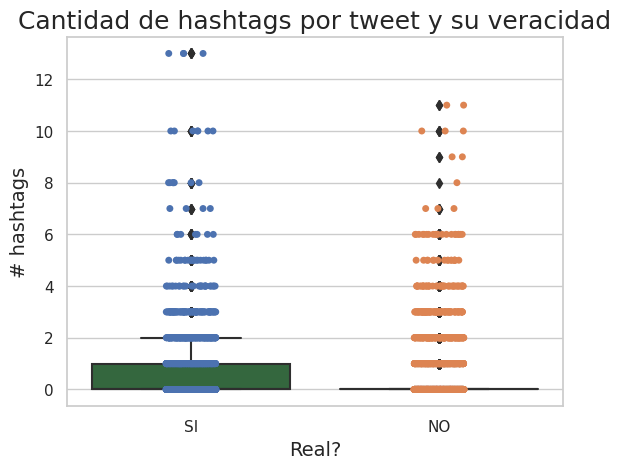

In [888]:
ax = sns.boxplot(x="target_name", y="hashtags_count", data=tweets, palette="cubehelix")
ax = sns.stripplot(x="target_name", y="hashtags_count", data=tweets) #scatterplot
ax.set_title("Cantidad de hashtags por tweet y su veracidad", fontsize=18)
ax.set_xlabel("Real?", fontsize=14)
ax.set_ylabel("# hashtags", fontsize=14)
plt.show()

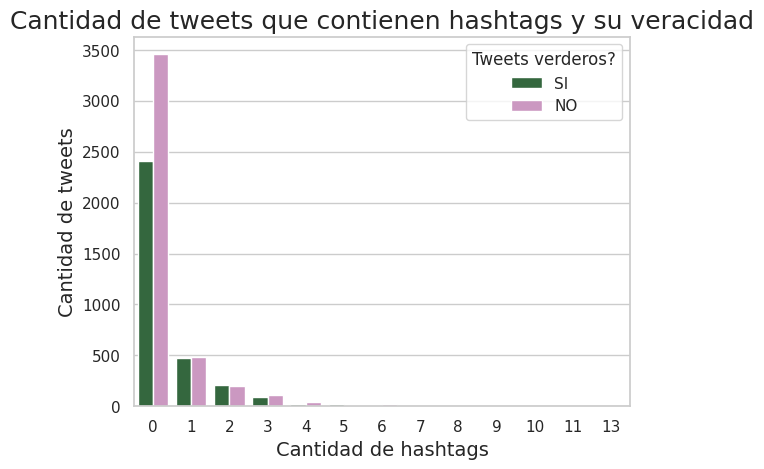

In [889]:
plot_hashtags_count = sns.countplot(x='hashtags_count',data=tweets,hue='target_name', palette="cubehelix")
plot_hashtags_count.set_title("Cantidad de tweets que contienen hashtags y su veracidad", fontsize=18)
plot_hashtags_count.set_xlabel("Cantidad de hashtags", fontsize=14)
plot_hashtags_count.set_ylabel("Cantidad de tweets", fontsize=14)
plot_hashtags_count.legend(loc='upper right', title='Tweets verderos?')

### Cantidad de tags

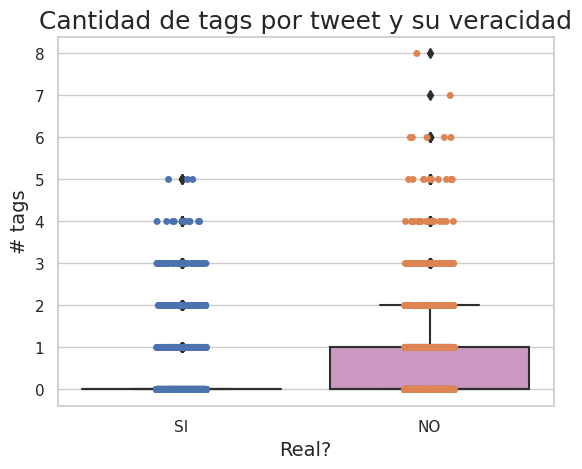

In [890]:
ax = sns.boxplot(x="target_name", y="tags_count", data=tweets, palette="cubehelix")
ax = sns.stripplot(x="target_name", y="tags_count", data=tweets) #scatterplot
ax.set_title("Cantidad de tags por tweet y su veracidad", fontsize=18)
ax.set_xlabel("Real?", fontsize=14)
ax.set_ylabel("# tags", fontsize=14)
plt.show()

### Cantidad de oraciones en el texto

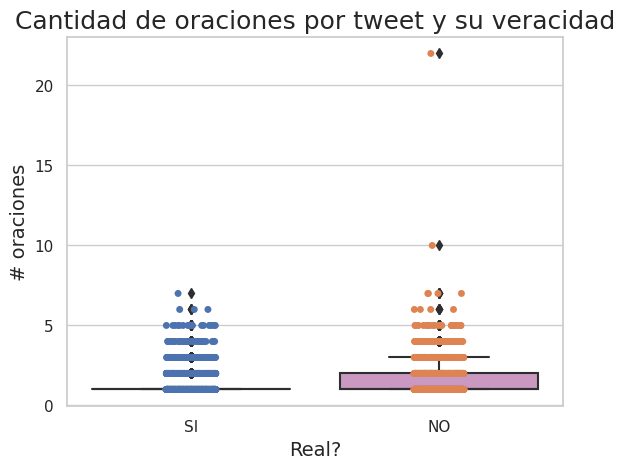

In [891]:
ax = sns.boxplot(x="target_name", y="sentences_count", data=tweets, palette="cubehelix")
ax = sns.stripplot(x="target_name", y="sentences_count", data=tweets) #scatterplot
ax.set_title("Cantidad de oraciones por tweet y su veracidad", fontsize=18)
ax.set_xlabel("Real?", fontsize=14)
ax.set_ylabel("# oraciones", fontsize=14)
plt.show()

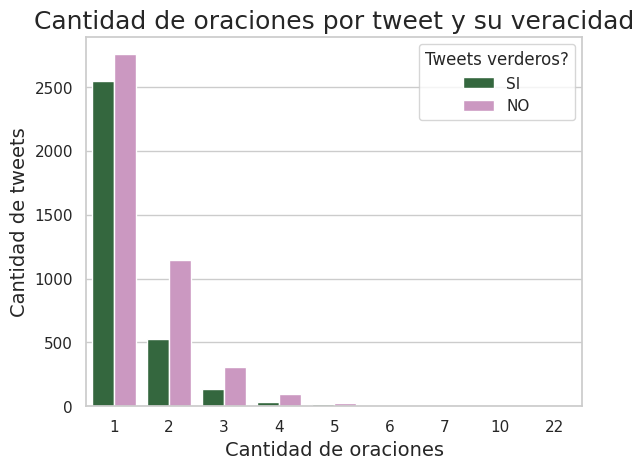

In [892]:
plot_sentences_count = sns.countplot(x='sentences_count',data=tweets,hue='target_name', palette="cubehelix")
plot_sentences_count.set_title("Cantidad de oraciones por tweet y su veracidad", fontsize=18)
plot_sentences_count.set_xlabel("Cantidad de oraciones", fontsize=14)
plot_sentences_count.set_ylabel("Cantidad de tweets", fontsize=14)
plot_sentences_count.legend(loc='upper right', title='Tweets verderos?')

### Análisis de los keywords

In [893]:
# Agrupo por keyword y cuento la cantidad de apariciones que tienen y el promedio del target para sacar una suerte de "probabilidad de catastrofe"
probability = tweets.groupby('keywords').agg({'target':'mean'}).rename(columns={'target':'Probabilidad de Catastrofe'})
probability.sort_values('Probabilidad de Catastrofe', ascending=False).head(10)

,Probabilidad de Catastrofe
keywords,
debris,1.00
wreckage,1.00
derailment,1.00
outbreak,0.97
oil spill,0.97
typhoon,0.97
suicide bombing,0.97
suicide bomber,0.97
bombing,0.93


Text(0.5, 0, 'Keyword')

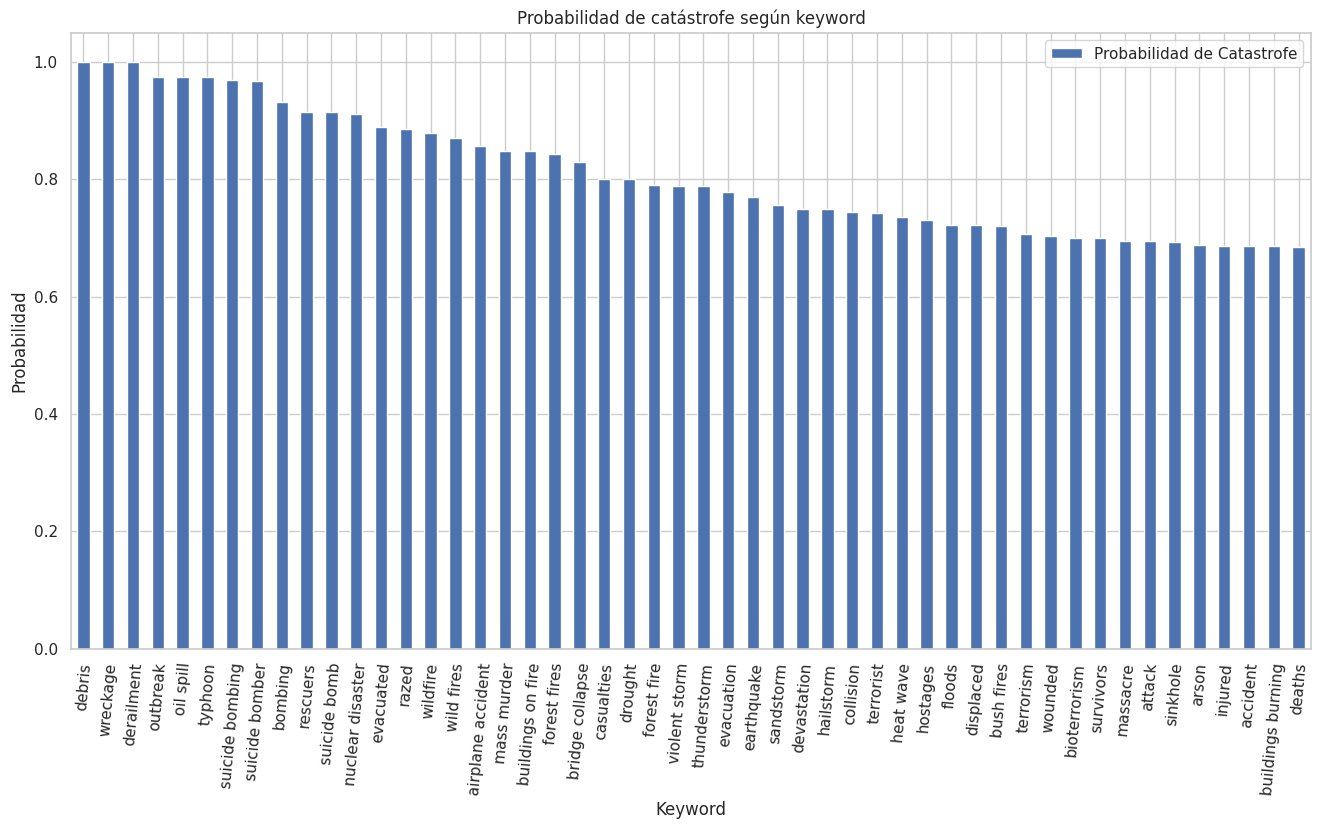

In [894]:
probability.sort_values('Probabilidad de Catastrofe', ascending=False).head(50).plot(kind='bar',figsize=(16,8),rot=85,title='Probabilidad de catástrofe según keyword')
ax=plt.gca()
ax.set_ylabel('Probabilidad');
ax.set_xlabel('Keyword')

### Análisis de sentimientos en el texto

In [895]:
sentiment_fakes = tweets[tweets.target == 0]['sentiment_score_compound']
sentiment_valid = tweets[tweets.target == 1]['sentiment_score_compound']

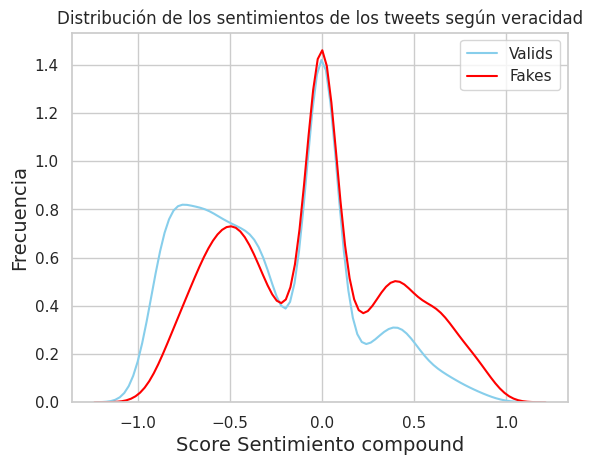

In [896]:
ax = sns.distplot( sentiment_valid , color="skyblue", label="Valids",hist=False)
ax = sns.distplot( sentiment_fakes , color="red", label="Fakes",hist=False)
plt.legend()
ax.set_title("Distribución de los sentimientos de los tweets según veracidad")
ax.set_xlabel("Score Sentimiento compound", fontsize=14)
ax.set_ylabel("Frecuencia", fontsize=14)
plt.show()

# los válidos tienen mas sentimientos negativos que positivos

### Nube de palabras

Wordcloud para textos fake

In [897]:
# me quedo con todos los textos fakes
fakes = tweets[tweets.target == 0]
fakes_text = " ".join(review for review in fakes.normalized_text)

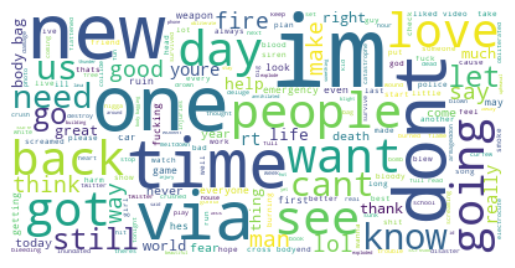

In [898]:
# Create and generate a word cloud image:
wordcloud_fake = WordCloud(max_font_size=80, max_words=500, background_color="white").generate(fakes_text)

# Display the generated image:
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_fake.to_file("wordcloud_fake.png")

Wordcloud para textos reales

In [899]:
# me quedo con todos los textos reales
reales= tweets[tweets.target == 1]
reales_text = " ".join(review for review in reales.normalized_text)

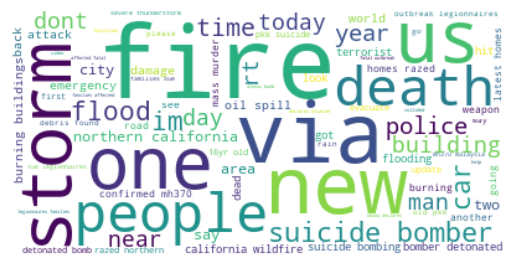

In [900]:
# Create and generate a word cloud image:
wordcloud_real = WordCloud(max_font_size=80, max_words=500, background_color="white").generate(reales_text)

# Display the generated image:
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_real.to_file("wordcloud_real.png")